# ÖDEV 1: PCA yardımı ile Classification,

Bu ödevde "Credit Risk Prediction" veri setini kullanacağız. Amacımız, verinin boyut sayısını düşürerek olabildiğince yüksek accuracy değerini alabilmek. Aşağıda verinin okunma ve temizlenme kısmını hazırlayıp vereceğim. Devamında ise yapmanız gerekenler:

1. PCA kullanarak verinin boyutunu düşürmek
    * Önce explained varience ratio değerini inceleyerek veriyi kaç boyuta düşürebileceğini kontrol et.
    * Daha sonra farklı boyutlarda denemeler yaparak boyutu düşürülmüş verileri elde et.
2. Classification modellerini dene
    * Logistic Regression
    * Random Forest
    * ve eğer istersen herhangi bir modelle daha

İsteğe bağlı olarak, verinin boyutunu düşürmek için diğer yöntemleri de kullanıp en yüksek accuracy değerini almayı deneyebilirsin.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df: pd.DataFrame = pd.read_csv('./credit_risk_dataset.csv')

In [3]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
print(df.isnull().sum())

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [5]:
# Null değerleri sütun ortalaması ile dolduruyoruz
df["person_emp_length"].fillna(df["person_emp_length"].median(), inplace=True)
df["loan_int_rate"].fillna(df["loan_int_rate"].median(), inplace=True)

In [6]:
df.duplicated().sum()

165

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32416.0,27.747008,6.354100,20.00,23.00,26.00,30.00,144.00
person_income,32416.0,66091.640826,62015.580269,4000.00,38542.00,55000.00,79218.00,6000000.00
person_emp_length,32416.0,4.768880,4.090411,0.00,2.00,4.00,7.00,123.00
loan_amnt,32416.0,9593.845632,6322.730241,500.00,5000.00,8000.00,12250.00,35000.00
loan_int_rate,32416.0,11.014662,3.083050,5.42,8.49,10.99,13.11,23.22
loan_status,32416.0,0.218688,0.413363,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32416.0,0.170250,0.106812,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32416.0,5.811297,4.059030,2.00,3.00,4.00,8.00,30.00


In [9]:
# Outlier temizliği
df = df[df['person_age']<=100]
df = df[df['person_emp_length'] <= 60]
df = df[df['person_income']<=4e6]

In [10]:
# Kategorik verileri alıyoruz ve one hot encoding haline getiriyoruz
cat_cols = pd.DataFrame(df[df.select_dtypes(include=['object']).columns])
cat_cols.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [11]:
encoded_cat_cols = pd.get_dummies(cat_cols)
df.drop(df.select_dtypes(include=['object']).columns, axis=1,inplace=True)
df = pd.concat([df,encoded_cat_cols], axis=1)

In [12]:
X = df.drop('loan_status', axis=1).values
y = df['loan_status'].values

In [14]:
df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,30,1,0,...,0,0,0,1,0,0,0,0,1,0
32577,54,120000,4.0,17625,7.49,0,0.15,19,1,0,...,0,1,0,0,0,0,0,0,1,0
32578,65,76000,3.0,35000,10.99,1,0.46,28,0,0,...,0,0,1,0,0,0,0,0,1,0
32579,56,150000,5.0,15000,11.48,0,0.10,26,1,0,...,0,0,1,0,0,0,0,0,1,0


In [15]:
X

array([[2.10e+01, 9.60e+03, 5.00e+00, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       [2.50e+01, 9.60e+03, 1.00e+00, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       [2.30e+01, 6.55e+04, 4.00e+00, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       ...,
       [6.50e+01, 7.60e+04, 3.00e+00, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       [5.60e+01, 1.50e+05, 5.00e+00, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       [6.60e+01, 4.20e+04, 2.00e+00, ..., 0.00e+00, 1.00e+00, 0.00e+00]])

In [18]:
train_idx

array([13526, 16071, 28054, ..., 22077, 11890, 27777], dtype=int64)

In [17]:
# Verileri train ve test olarak ikiye ayırıyoruz

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(1, test_size=0.1)
train_idx, test_idx = next(split.split(X, y))
train_x = X[train_idx]
test_x = X[test_idx]

train_y = y[train_idx]
test_y = y[test_idx]

## Kolay gelsin!

### PCA as dimensionality reduction

In [19]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA

In [86]:
#5D

pca_5d = PCA(n_components=5)

X_train_5d = pca_5d.fit_transform(train_x)
X_test_5d = pca_5d.fit_transform(test_x)

print("Original shape:   ", X_train_5d.shape)
print("Transformed shape:", X_train_5d.shape)

print("Variance Ratio: ")
for i in range(len(pca_5d.explained_variance_ratio_)):
    print(pca_5d.explained_variance_ratio_[i])
    
print("{:.12f}".format(1 - pca_5d.explained_variance_ratio_.sum()))

Original shape:    (29168, 5)
Transformed shape: (29168, 5)
Variance Ratio: 
0.9844839724647122
0.015515989556032794
2.395252724558306e-08
7.208549322586074e-09
4.525838054404968e-09
0.000000002292


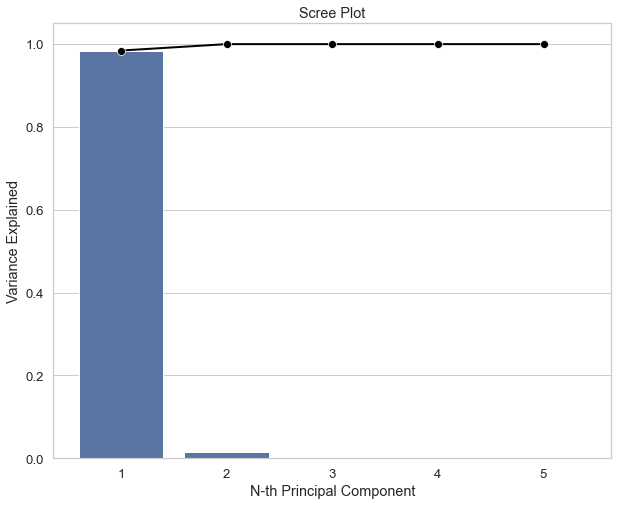

In [87]:
PC_components = np.arange(pca_5d.n_components_) + 1

_ = sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.barplot(x = PC_components, y=pca_5d.explained_variance_ratio_, color='b')
_ = sns.lineplot(x = PC_components-1, y=np.cumsum(pca_5d.explained_variance_ratio_), 
                 color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [64]:
#3D
pca_3d = PCA(n_components=3)

X_train_3d = pca_3d.fit_transform(train_x)
X_test_3d = pca_3d.fit_transform(test_x)

print("Original shape:   ", X_train_3d.shape)
print("Transformed shape:", X_train_3d.shape)

print("Variance Ratio: ")
for i in range(len(pca_3d.explained_variance_ratio_)):
    print(pca_3d.explained_variance_ratio_[i])
    
print("{:.12f}".format(1 - pca_3d.explained_variance_ratio_.sum()))

Original shape:    (29168, 3)
Transformed shape: (29168, 3)
Variance Ratio: 
0.9844839724647109
0.015515989556032804
2.395252724558304e-08
0.000000014027


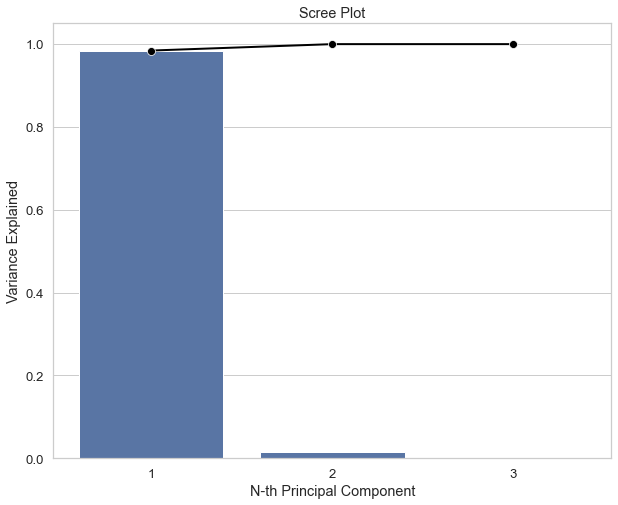

In [85]:
# Scree Plot
import seaborn as sns
PC_components = np.arange(pca_3d.n_components_) + 1

_ = sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.barplot(x = PC_components, y=pca_3d.explained_variance_ratio_, color='b')
_ = sns.lineplot(x = PC_components-1, y=np.cumsum(pca_3d.explained_variance_ratio_), 
                 color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.show()

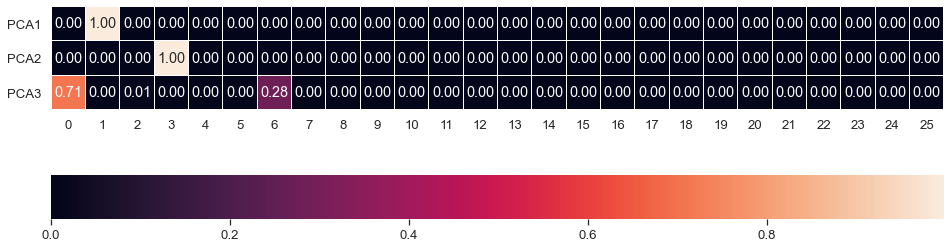

In [109]:
# Feature Weight Heatmap

fig, ax = plt.subplots(figsize=(16, 8))
_ = sns.heatmap(pca_3d.components_**2,
                 yticklabels=["PCA"+str(x) for x in range(1,pca_3d.n_components_+1)],
                 annot=True,
                 fmt='.2f',
                 square=True,
                 linewidths=0.05,
                 cbar_kws={"orientation": "horizontal"})

In [110]:
#2D
pca_2d = PCA(n_components=2)

X_train_2d = pca_2d.fit_transform(train_x)
X_test_2d = pca_2d.fit_transform(test_x)

print("Original shape:   ", X_train_2d.shape)
print("Transformed shape:", X_train_2d.shape)

print("Variance Ratio: ")
for i in range(len(pca_2d.explained_variance_ratio_)):
    print(pca_2d.explained_variance_ratio_[i])
    
print("{:.12f}".format(1 - pca_2d.explained_variance_ratio_.sum()))

Original shape:    (29168, 2)
Transformed shape: (29168, 2)
Variance Ratio: 
0.9844839724647109
0.015515989556032794
0.000000037979


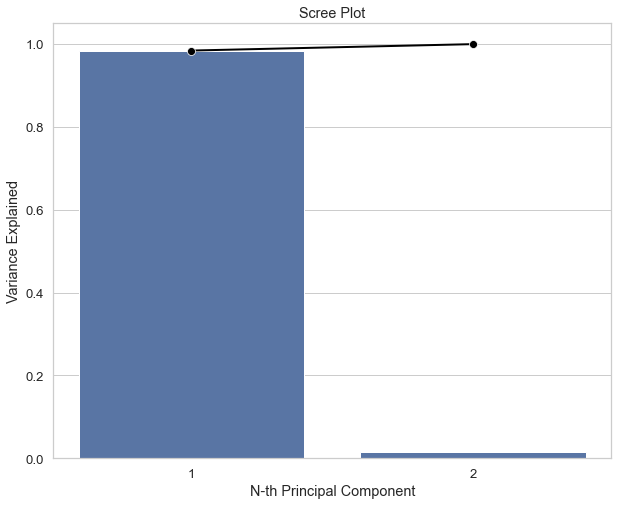

In [111]:
# Scree Plot
import seaborn as sns
PC_components = np.arange(pca_2d.n_components_) + 1

_ = sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.barplot(x = PC_components, y=pca_2d.explained_variance_ratio_, color='b')
_ = sns.lineplot(x = PC_components-1, y=np.cumsum(pca_2d.explained_variance_ratio_), 
                 color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.show()

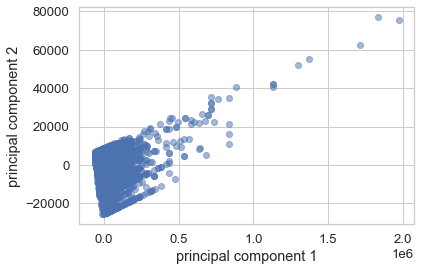

In [97]:
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], alpha=0.5)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.show()

#### Since approximately 99% of the model can be captured with 2 PCA components, I choose the component count as 2.

## Model Run

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Logistic Regression

In [129]:
LR_model = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_2d, train_y)
print("Logistic Regression Accuracy: ", metrics.accuracy_score(test_y, LR_model.predict(X_test_2d)))
print("\nLogistic Regression Classification Report: \n", classification_report(test_y,  LR_model.predict(X_test_2d)))

Logistic Regression Accuracy:  0.7935822277074976

Logistic Regression Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.98      0.88      2532
           1       0.65      0.12      0.20       709

    accuracy                           0.79      3241
   macro avg       0.73      0.55      0.54      3241
weighted avg       0.77      0.79      0.73      3241



### Decision Tree

In [132]:
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_train_2d, train_y)

print("Decision Tree Accuracy: ", metrics.accuracy_score(test_y, DT_model.predict(X_test_2d)))
print("\nDecision Tree Classification Report: \n", classification_report(test_y,  DT_model.predict(X_test_2d)))

Decision Tree Accuracy:  0.8235112619561864

Decision Tree Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      2532
           1       0.69      0.36      0.47       709

    accuracy                           0.82      3241
   macro avg       0.76      0.66      0.68      3241
weighted avg       0.81      0.82      0.80      3241



### Random Forest

In [133]:
param = [
    {'n_estimators': [200, 300, 400], 
     'max_depth': [5, 6, 7, 8, 9], 
     'max_leaf_nodes': [15, 20, 25]}, 
]
RF_model = RandomForestClassifier()
RF_gscv = GridSearchCV(RF_model, param, cv = 5, n_jobs = -1, verbose = 1)
RF_gscv.fit(X_train_2d, train_y)
RF_best = RF_gscv.best_estimator_
pred = RF_gscv.predict(X_test_2d)
RF_gscv.best_estimator_, RF_gscv.score(X_train_2d, train_y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


(RandomForestClassifier(max_depth=5, max_leaf_nodes=25, n_estimators=400),
 0.8424300603400987)

In [134]:
print("Random Forest Tree Accuracy: ", metrics.accuracy_score(test_y, RF_gscv.predict(X_test_2d)))
print("\nRandom Forest Classification Report: \n", classification_report(test_y,  RF_gscv.predict(X_test_2d)))

Random Forest Tree Accuracy:  0.8293736501079914

Random Forest Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.95      0.90      2532
           1       0.70      0.38      0.49       709

    accuracy                           0.83      3241
   macro avg       0.77      0.67      0.70      3241
weighted avg       0.82      0.83      0.81      3241

